In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

from torchmetrics import Accuracy

In [2]:
### Data Loading
from datasets import CIFAR10, get_train_loader, get_test_loader

root_dir = "/mnt/d/datasets/cifar10"
train_loader = get_train_loader(dataset=CIFAR10(root_dir, "train"), batch_size=64)
test_loader = get_test_loader(dataset=CIFAR10(root_dir, "test"), batch_size=32)

batch = next(iter(train_loader))
images, labels = batch["image"], batch["label"]
print(f"train images: {images.shape}, {images.dtype}, {images.min()}, {images.max()}")
print(f"train labels: {labels.shape}, {labels.dtype}, {labels.min()}, {labels.max()}")

batch = next(iter(test_loader))
images, labels = batch["image"], batch["label"]
print(f"test  images: {images.shape}, {images.dtype}, {images.min()}, {images.max()}")
print(f"test  labels: {labels.shape}, {labels.dtype}, {labels.min()}, {labels.max()}")

train images: torch.Size([64, 3, 32, 32]), torch.float32, 0.0, 1.0
train labels: torch.Size([64]), torch.int64, 0, 9
test  images: torch.Size([32, 3, 32, 32]), torch.float32, 0.0, 1.0
test  labels: torch.Size([32]), torch.int64, 0, 9


In [ ]:
### Modeling

class MLP(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super().__init__()
        self.in_channels = in_channels
        self.linear1 = nn.Sequential(nn.Linear(32 * 32 * in_channels, 512), nn.ReLU())
        self.linear2 = nn.Sequential(nn.Linear(512, 256), nn.ReLU())
        self.fc = nn.Linear(256, num_classes)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.loss_fn = nn.CrossEntropyLoss()
        self.acc_metric = Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * self.in_channels)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.fc(x)
        return x

    def train_step(self, batch, optimizer):
        images = batch["image"].to(self.device)
        labels = batch["label"].to(self.device)

        optimizer.zero_grad()
        logits = self.forward(images)
        loss = self.loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            preds = torch.softmax(logits, dim=1).argmax(dim=1)
            acc = self.acc_metric(preds, labels)
        return dict(loss=loss, acc=acc)

    @torch.no_grad()
    def eval_step(self, batch):
        images = batch["image"].to(self.device)
        labels = batch["label"].to(self.device)

        logits = self.forward(images)
        loss = self.loss_fn(logits, labels)

        preds = torch.softmax(logits, dim=1).argmax(dim=1)
        acc = self.acc_metric(preds, labels)
        return dict(loss=loss, acc=acc)
    
    @torch.no_grad()
    def pred_step(self, batch):
        images = batch["image"].to(self.device)
        labels = batch["label"]
        logits = self.forward(images)
        preds = torch.softmax(logits, dim=1).argmax(dim=1)
        return dict(images=images, labels=labels, preds=preds)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(in_channels=3, num_classes=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [8]:
### Training
from trainer import fit

history = fit(model, train_loader, optimizer, num_epochs=10, valid_loader=None)


[  1/10] loss:1.840, acc:0.330
[  2/10] loss:1.663, acc:0.402
[  3/10] loss:1.578, acc:0.435
[  4/10] loss:1.520, acc:0.456
[  5/10] loss:1.475, acc:0.473
[  6/10] loss:1.447, acc:0.481
[  7/10] loss:1.411, acc:0.495
[  8/10] loss:1.380, acc:0.506
[  9/10] loss:1.368, acc:0.511
[ 10/10] loss:1.339, acc:0.520


In [9]:
### Evaluation
from trainer import evaluate

evaluate(model, test_loader)

{'loss': 1.435754560661316, 'acc': 0.4902}

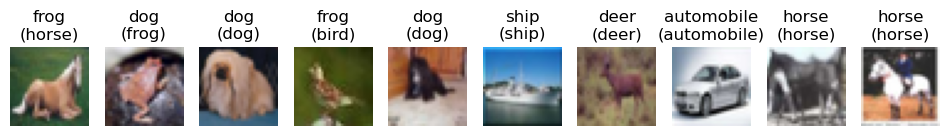

In [11]:
### Inference
from trainer import predict

predictions = predict(model, test_loader)
images = predictions["images"]
labels = predictions["labels"]
preds = predictions["preds"]

class_names = CIFAR10.CLASS_NAMES
num_samples = 10
indices = np.random.choice(len(images), size=num_samples, replace=False)

fig, axes = plt.subplots(1, num_samples, figsize=(12, 4))
for i, idx in enumerate(indices):
    axes[i].imshow(images[idx])
    axes[i].set_title(f"{class_names[preds[idx]]}\n({class_names[labels[idx]]})")
    axes[i].axis('off')

fig.tight_layout
plt.show()